# Task 2
## Prediction of m6A sites in all SG-NEx direct RNA-Seq samples 
<ul>
<li> Predict m6A RNA modifications in all samples from the SG-NEx data using our own method </li>
<li> Describe the results and compare them across the different cell lines </li>
<li> Summarise and visualise your observations </li>
</ul>

<b>Submission</b>: Describe the results and compare them across the different cell lines. Summarise and visualise your observations.

# Importing modules and functions

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import joblib
import numpy as np
import torch
import torch.nn as nn
import sys
import os

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split

In [2]:
%run "../code/data_pre_process.py"

In [3]:
%run "../code/feature_eng_pipeline.py"

# Creating a Task 2 original merged dataset 
## Loading and processing the dataset 


## TO run when agg_task2_merged.csv not created.

In [4]:
# Takes about 5 minutes to load 
# A549 Lung cell line 
a549_rep5_df = pd.read_csv("../dataset/CSV/A549_replicate5_data.csv") # change input path accordingly 
a549_rep6_df = pd.read_csv("../dataset/CSV/A549_replicate6_data.csv")

# HCT116 Colon cell line
hct116_rep3_df = pd.read_csv("../dataset/CSV/HCT116_replicate3_data.csv")
hct116_rep3_run4_df = pd.read_csv("../dataset/CSV/HCT116_replicate3_run4_data.csv")
hct116_rep4_run3_df = pd.read_csv("../dataset/CSV/HCT116_replicate4_run3_data.csv")

# HepG2 Liver cell line
hepg2_rep5_df = pd.read_csv("../dataset/CSV/hepG2_replicate5_data.csv")
hepg2_rep6_df = pd.read_csv("../dataset/CSV/hepG2_replicate6_data.csv")

# K562 Leukocytes cell line
k562_rep4_df = pd.read_csv("../dataset/CSV/k562_replicate4_data.csv")
k562_rep5_df = pd.read_csv("../dataset/CSV/k562_replicate5_data.csv")
k562_rep6_df = pd.read_csv("../dataset/CSV/k562_replicate6_data.csv")

# MCF7 Breast cell line
mcf7_rep3_df = pd.read_csv("../dataset/CSV/mcf7_replicate3_data.csv")
mcf7_rep4_df = pd.read_csv("../dataset/CSV/mcf7_replicate4_data.csv")

# List of orig df 
orig_df_list = [a549_rep5_df, a549_rep6_df, hct116_rep3_df, hct116_rep3_run4_df, hct116_rep4_run3_df, hepg2_rep5_df,
                hepg2_rep6_df, k562_rep4_df, k562_rep5_df, k562_rep6_df, mcf7_rep3_df, mcf7_rep4_df ]

Aggregated dataset based on mean 

In [5]:
# A549 Lung cell line
a549_df = data_agg_mean(pd.concat([a549_rep5_df, a549_rep6_df], axis = 0))

# HCT116 Colon cell line
hct116_df = data_agg_mean(pd.concat([hct116_rep3_df, hct116_rep3_run4_df, hct116_rep4_run3_df], axis = 0))

# HepG2 Liver cell line
hepg2_df = data_agg_mean(pd.concat([hepg2_rep5_df, hepg2_rep6_df], axis = 0))

# K562 Leukocytes cell line
k562_df = data_agg_mean(pd.concat([k562_rep4_df, k562_rep5_df, k562_rep6_df], axis = 0))

# MCF7 Breast cell line
mcf7_df = data_agg_mean(pd.concat([mcf7_rep3_df, mcf7_rep4_df], axis = 0))

# List of agg df
agg_df_list = [a549_df, hct116_df, hepg2_df, k562_df, mcf7_df]

In [6]:
cell_line_name = ['A549', 'HCT116', 'HEPG2', 'K562', 'MCF7']
agg_df_list[0]["cell_line_name"] = cell_line_name[0]
agg_merged_df = agg_df_list[0]
for i in range(1, len(agg_df_list)):
    agg_df_list[i]["cell_line_name"] = cell_line_name[i]
    agg_merged_df = pd.concat([agg_merged_df, agg_df_list[i]], axis = 0)

agg_merged_df.to_csv("../dataset/agg_task2_merged.csv", index = False)

In [7]:
# Check
total_count = 0
for df in agg_df_list:
    total_count += len(df)
print(total_count)

assert total_count == len(agg_merged_df), "Please check the merge of raw data."

9733664


# Creating Task 2 predicted dataset

## TO run when pred_merged.csv not written

In [8]:
a549_pred_df= pd.read_csv("../code/prediction/ModNet_predict_on_a549.csv") # transcript_id | transcript_position | score
hct116_pred_df = pd.read_csv("../code/prediction/ModNet_predict_on_hct116.csv")
hepg2_pred_df = pd.read_csv("../code/prediction/ModNet_predict_on_hepg2.csv")
k562_pred_df = pd.read_csv("../code/prediction/ModNet_predict_on_k562.csv")
mcf7_pred_df = pd.read_csv("../code/prediction/ModNet_predict_on_mcf7.csv")

pred_list = [a549_pred_df, hct116_pred_df, hepg2_pred_df, k562_pred_df, mcf7_pred_df]

In [9]:
cell_line_name = ['A549', 'HCT116', 'HEPG2', 'K562', 'MCF7']
pred_list[0]["cell_line_name"] = cell_line_name[0]
pred_df = pred_list[0]
for i in range(1, len(agg_df_list)):
    pred_list[i]["cell_line_name"] = cell_line_name[i]
    pred_df = pd.concat([pred_df, pred_list[i]], axis = 0)

pred_df.to_csv("../dataset/pred_merged.csv", index = False)

In [10]:
# Check
total_count = 0
for df in pred_list:
    total_count += len(df)
print(total_count)

assert total_count == len(pred_df), "Please check the merge of raw data."

9733664


# Descriptive analytics 

In [18]:
agg_merged_df = pd.read_csv("../dataset/agg_task2_merged.csv")
pred_df = pd.read_csv("../dataset/pred_merged.csv")

In [19]:
pred_df['labels'] = pred_df['score'].apply(lambda x: 1 if x >= 0.85 else 0)
pred_df.columns

Index(['transcript_id', 'transcript_position', 'score', 'cell_line_name',
       'labels'],
      dtype='object')

## 1. Using dataset after agg_mean and before prediction 
### Bar graphs to show the number of unique (transcripts, position) for each cell line

In [36]:
df = agg_merged_df[['cell_line_name', 'transcript_name', 'json_position']].drop_duplicates()
final_count = df.groupby('cell_line_name').size().reset_index(name = "count")
print(final_count)

  cell_line_name    count
0           A549  1632577
1         HCT116  1963526
2          HEPG2  1879601
3           K562  1559321
4           MCF7  2698639


Text(0.5, 1.0, 'Number of unique transcript names at each cell line')

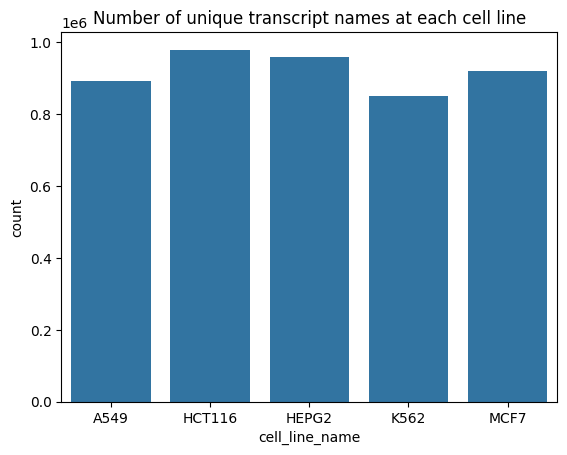

In [43]:
sns.barplot(data = final_count, x = 'cell_line_name', y = 'count')
plt.title("Number of unique transcript names at each cell line")

# Higher number of transcript counts in a cell line signifies greater complexity in a gene expression 

### Bar graphs to show the number of unique (5mers, position) at each cell line 

In [40]:
ns_df = agg_merged_df[['cell_line_name', 'nucleotide_seq', 'json_position']].drop_duplicates()
ns_final_count = ns_df.groupby('cell_line_name').size().reset_index(name = "count")
print(ns_final_count)

  cell_line_name   count
0           A549  891555
1         HCT116  980007
2          HEPG2  960471
3           K562  851985
4           MCF7  920025


Text(0.5, 1.0, 'Number of unique 5-mers at each cell line')

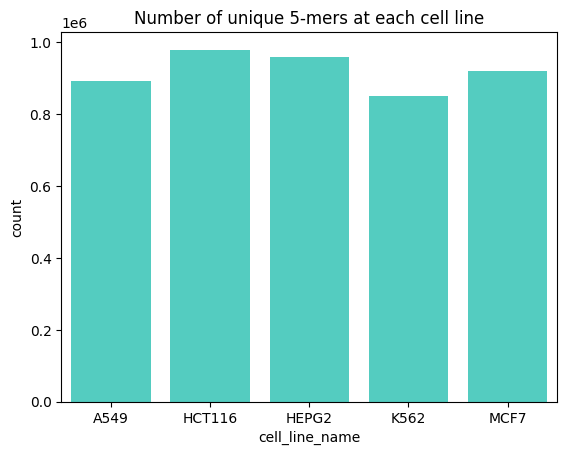

In [56]:
sns.barplot(data = ns_final_count, x = 'cell_line_name', y = 'count', color = "turquoise")
plt.title("Number of unique 5-mers at each cell line")

### Finding the difference in dwelling time for the -1 position, 0 position and +1 position.

<Axes: xlabel='variable', ylabel='value'>

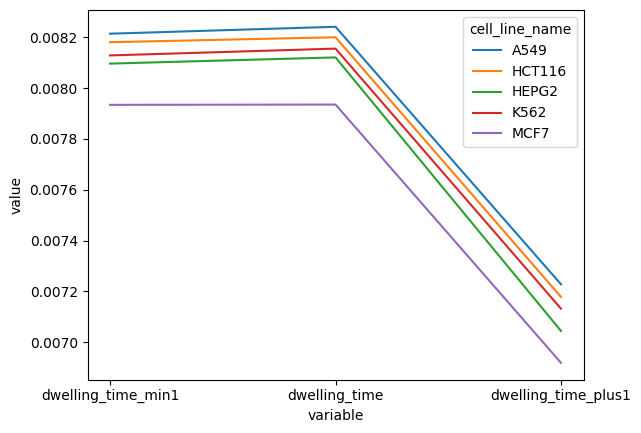

In [ ]:
difference_df = agg_merged_df
difference_df = difference_df.groupby("cell_line_name")[["dwelling_time_min1", "dwelling_time", "dwelling_time_plus1"]].mean().reset_index()
difference_df = difference_df.melt(id_vars = "cell_line_name",
                                   value_vars = ["dwelling_time_min1", "dwelling_time", "dwelling_time_plus1"],
                                   )
sns.lineplot(data = difference_df, x = 'variable', y = 'value', hue = 'cell_line_name')

## 2. Using predicted dataset 

### Determining the percentage of predicted 0 and 1 labels in each cell line.

In [20]:
remove_dup_df = pred_df.drop_duplicates(keep=False)
final_df = remove_dup_df.groupby(['cell_line_name', 'labels'])['transcript_id'].nunique().reset_index()
total_count = final_df.groupby('cell_line_name')['transcript_id'].transform('sum')
final_df['percentage'] = (final_df['transcript_id']/total_count) * 100
print(final_df)

  cell_line_name  labels  transcript_id  percentage
0           A549       0          47054   60.025513
1           A549       1          31336   39.974487
2         HCT116       0          57059   59.647711
3         HCT116       1          38601   40.352289
4          HEPG2       0          52703   60.517643
5          HEPG2       1          34384   39.482357
6           K562       0          53145   61.578124
7           K562       1          33160   38.421876
8           MCF7       0          89723   61.465476
9           MCF7       1          56250   38.534524


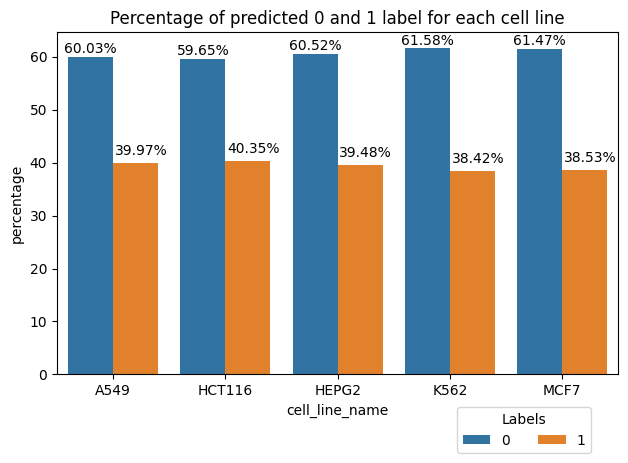

In [22]:
barplot = sns.barplot(data = final_df, x = 'cell_line_name', y = 'percentage', hue = 'labels')
for index, row in final_df.iterrows():
    # Adjust x and y positions as needed
    if index % 2 == 0:
        x_pos = index % 2  + (index // 2) -0.2 # Offset for bar position
        y_pos = row['percentage'] + 0.2 # Position slightly above the bar
        barplot.text(x_pos, y_pos, f"{round(row['percentage'], 2)}%", 
                    ha='center', va='bottom')
    else:
        x_pos = (index-0.75)% 2  + ((index -0.7)// 2)  # Offset for bar position
        y_pos = row['percentage'] + 1 # Position slightly above the bar
        barplot.text(x_pos, y_pos, f"{round(row['percentage'], 2)}%", 
                    ha='center', va='bottom')

plt.title("Percentage of predicted 0 and 1 label for each cell line")
plt.legend(title='Labels', loc='lower left', bbox_to_anchor=(0.7, -0.25), ncol=2)
plt.tight_layout()
plt.show()

## Threshold of probability vs labels 


## 1. Illustrate the approach 
Shows the data processing and analysis approach 
- data processing: aggregating all the reads by obtaining the mean 

Show the number of change in number of rows before and after aggregation

## 2. Relative location of m6A along mRNAs 
Lecture mentioned: Metagene plot to show the relative position of detected m6A sites across all transcripts. m6A expected to occur between the coding sequence and 3' UTR 

## 3. Analyse the features that we are using
Which features differ between modified and unmodified sites? Does this look similar across the cell lines? 

## 4. Compare m6A across all cell lines 
Do you observe that m6A is similar between cell lines, or different?

Which cell lines are more similar?

How many sites are shared, how many are unique?

## 5. Investigate individual sites/ genes 
Which genes are highly modified?

Which genes show differences across cell lines?

Visualise results for individual genes 

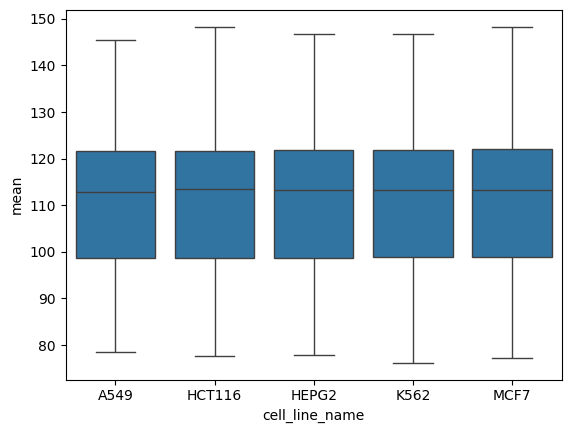

In [29]:
sns.boxplot(x = 'cell_line_name', y = 'mean', data = agg_merged_df)
plt.show()